### Importing relevant libraries:

In [52]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model
import cv2

### Creating the path for train and test data:

In [53]:
train_dir = '/home/aravind_sundarraj0112/train/'
test_dir = '/home/aravind_sundarraj0112/test/'

### Importing Data for both train and test data:

In [54]:
row, col = 48, 48                                        # Dimension of the image data
classes = 7                                              # Numnber of classes 

def count_exp(path, set_):                               # Creating a dataframe for train and test dataset with the frequencies of respective classes
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)                                       # Printing the number of expressions in each class of train data
print(test_count)                                        # Printing the number of expressions in each class of test data

       disgust  surprise  fear  happy  neutral   sad  angry
train      436      3171  4097   7215     4965  4830   3995
      disgust  surprise  fear  happy  neutral   sad  angry
test      111       831  1024   1774     1233  1247    958


In [55]:
train_count.iloc[0].values

array([ 436, 3171, 4097, 7215, 4965, 4830, 3995])

### Plotting the frequencies of all the classes in train data:

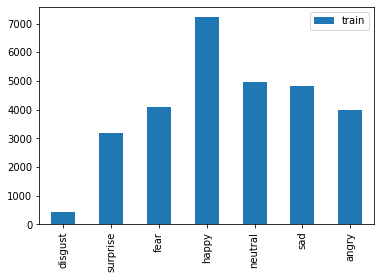

In [56]:
train_count.transpose().plot(kind='bar')
plt.show()

### Plotting the frequencies for all the classes in test data:

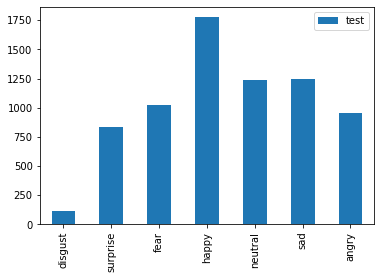

In [57]:
test_count.transpose().plot(kind='bar')
plt.show()

### List of all expressions:

In [58]:
os.listdir(train_dir)

['disgust', 'surprise', 'fear', 'happy', 'neutral', 'sad', 'angry']

### Displaying images: a small sample

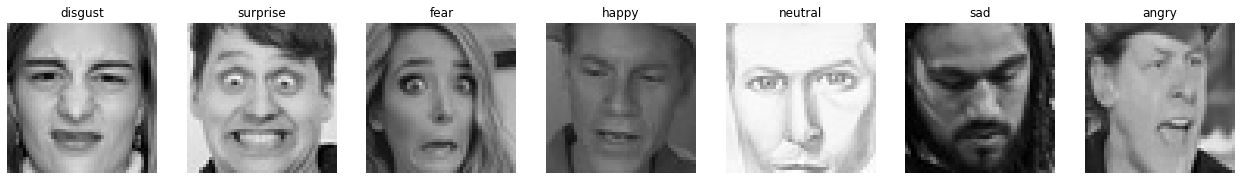

In [59]:
plt.figure(figsize=(22,22))
i = 1
for expression in os.listdir(train_dir):
    img = cv2.imread(train_dir + expression +'/'+ os.listdir(train_dir + expression)[1])
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

### Creating training and test sets:

In [60]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Indices of all classes :

In [61]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

### CNN :

In [62]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

### Summary:

In [63]:
dnet = get_model((row,col,1), classes)
dnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 128)      

/home/aravind_sundarraj0112/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### Callbacks function :

In [64]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

### Training model : 

In [65]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = dnet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=30,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/30
448/448 [==============================] - ETA: 0s - loss: 4.2731 - accuracy: 0.2792
Epoch 1: val_loss improved from inf to 7.80101, saving model to ferNet.h5
448/448 [==============================] - 358s 794ms/step - loss: 4.2731 - accuracy: 0.2792 - val_loss: 7.8010 - val_accuracy: 0.1456 - lr: 1.0000e-04
Epoch 2/30
448/448 [==============================] - ETA: 0s - loss: 3.5109 - accuracy: 0.3368
Epoch 2: val_loss improved from 7.80101 to 3.15881, saving model to ferNet.h5
448/448 [==============================] - 356s 794ms/step - loss: 3.5109 - accuracy: 0.3368 - val_loss: 3.1588 - val_accuracy: 0.3802 - lr: 1.0000e-04
Epoch 3/30
448/448 [==============================] - ETA: 0s - loss: 2.9974 - accuracy: 0.3608
Epoch 3: val_loss improved from 3.15881 to 2.69398, saving model to ferNet.h5
448/448 [==============================] - 340s 760ms/step - loss: 2.9974 - accuracy: 0.3608 - val_loss: 2.6940 - val_accuracy: 0.4064 - lr: 1.0000e-04
Epoch 4/30
448/448 [======

Epoch 27/30
448/448 [==============================] - ETA: 0s - loss: 0.9171 - accuracy: 0.6915
Epoch 27: val_loss did not improve from 1.09336
448/448 [==============================] - 333s 744ms/step - loss: 0.9171 - accuracy: 0.6915 - val_loss: 1.1002 - val_accuracy: 0.6349 - lr: 1.0000e-04
Epoch 28/30
448/448 [==============================] - ETA: 0s - loss: 0.8926 - accuracy: 0.7042
Epoch 28: val_loss did not improve from 1.09336
448/448 [==============================] - 333s 744ms/step - loss: 0.8926 - accuracy: 0.7042 - val_loss: 1.0995 - val_accuracy: 0.6343 - lr: 1.0000e-04
Epoch 29/30
448/448 [==============================] - ETA: 0s - loss: 0.8785 - accuracy: 0.7114
Epoch 29: val_loss did not improve from 1.09336
448/448 [==============================] - 334s 746ms/step - loss: 0.8785 - accuracy: 0.7114 - val_loss: 1.1066 - val_accuracy: 0.6339 - lr: 1.0000e-04
Epoch 30/30
448/448 [==============================] - ETA: 0s - loss: 0.8597 - accuracy: 0.7165
Epoch 30: va

### Loss and accuracy plot

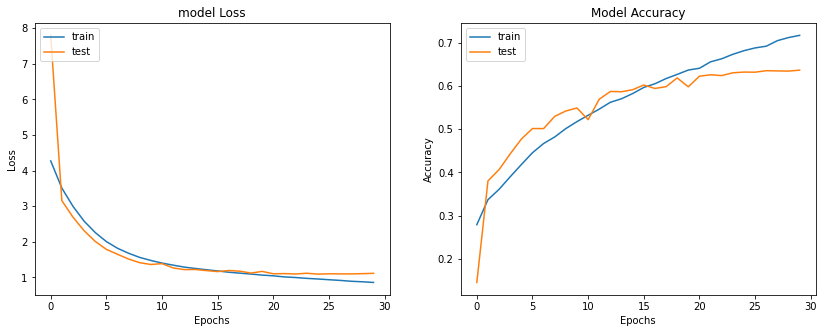

In [66]:
plt.figure(figsize=(14,5))
 
plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
  

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.show()  

### Model evaluation: 

In [68]:
train_loss, train_accu = dnet.evaluate(training_set)
test_loss, test_accu = dnet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 11s 99ms/step - loss: 1.1156 - accuracy: 0.6362
final train accuracy = 79.43 , validation accuracy = 63.62


In [69]:
dnet.save_weights('fernet_bestweight.h5')

### Confusion Matrix and Classification on training set:

449/449 [==============================] - 48s 106ms/step
Confusion Matrix
[[ 545   47  581  947  779  653  443]
 [  76    3   55  109   89   67   37]
 [ 558   65  577  996  805  650  446]
 [ 974   80 1055 1733 1404 1189  780]
 [ 653   55  732 1226  929  810  560]
 [ 639   56  660 1179  955  805  536]
 [ 450   23  452  816  581  516  333]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3995
     disgust       0.01      0.01      0.01       436
        fear       0.14      0.14      0.14      4097
       happy       0.25      0.24      0.24      7215
     neutral       0.17      0.19      0.18      4965
         sad       0.17      0.17      0.17      4830
    surprise       0.11      0.11      0.11      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



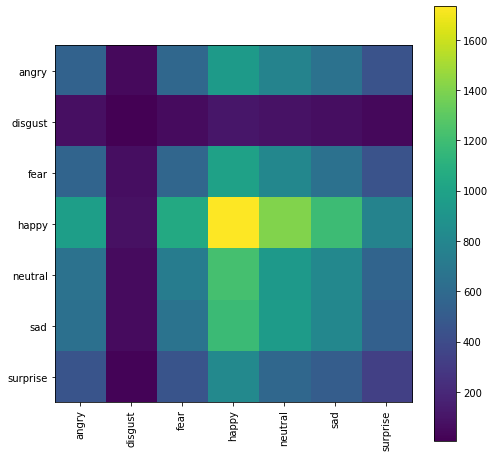

In [71]:
y_pred = dnet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

### Confusion matrix and classification on test set:

113/113 [==============================] - 12s 108ms/step
Confusion Matrix
[[139   8 151 208 234 106 112]
 [ 22   1  18  21  24  14  11]
 [146   8 143 233 214 165 115]
 [246  18 246 421 380 280 183]
 [183   7 177 300 246 180 140]
 [173  14 160 305 277 187 131]
 [107   5 136 200 162 127  94]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.15      0.14       958
     disgust       0.02      0.01      0.01       111
        fear       0.14      0.14      0.14      1024
       happy       0.25      0.24      0.24      1774
     neutral       0.16      0.20      0.18      1233
         sad       0.18      0.15      0.16      1247
    surprise       0.12      0.11      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



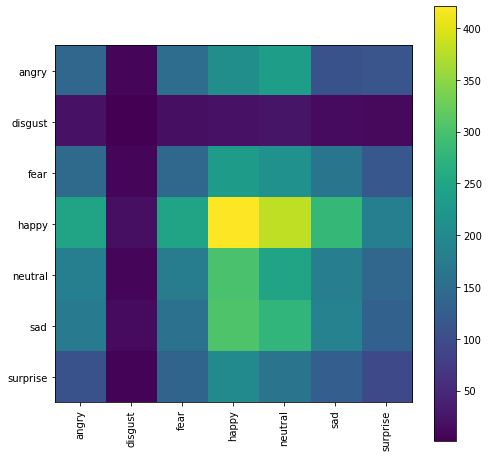

In [73]:
y_pred = dnet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)